# Active learning using kili-technology

In this tutorial, we will see results of active learning applied to object detection.

It is no secret that machine learning models, especially deep learning models, need lots of training data. In the real world, unsupervised data is plenty while supervised data is rare and costly to obtain. Thus, you may be interested in using active learning : it is the task of choosing well the data samples to annotate to get the best performance given a fixed number of annotations.

At kili-technology, we develop the best annotation platform, to quickly get a production ready dataset. One of the features of our python - graphQL API is the ability to order the data samples to annotate, by giving them priority. This allows the use of active learning algorithms.

In [1]:
!git clone https://github.com/mDuval1/SSD

fatal: destination path 'SSD' already exists and is not an empty directory.


In [2]:
import glob
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_models = glob.glob('SSD/outputs/*')

In [4]:
list_df = []
for data_model in data_models:
    model_results = glob.glob(f'{data_model}/results/*')
    for model_result in model_results:
        df_model = pd.read_csv(model_result)
        df_model['model'] = model_result.split('/')[-1]
        df_model['data'] = data_model.split('/')[-1]
        list_df.append(df_model)

In [5]:
df = pd.concat(list_df).reset_index()

In [6]:
df

,index,strategy,args,step,mAP,model,data
0,0,random_sampling,{},1,0.206222,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
1,1,random_sampling,{},2,0.268997,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
2,2,random_sampling,{},3,0.326994,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
3,3,random_sampling,{},4,0.344545,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
4,4,random_sampling,{},5,0.364667,random_sampling-20200621170027.txt,mobilenet_v2_ssd320_voc0712
...,...,...,...,...,...,...,...
75,9,random_sampling,{},10,0.432848,random_sampling-20200621151902.txt,mobilenet_v2_ssd320_voc0712
76,10,random_sampling,{},11,0.439631,random_sampling-20200621151902.txt,mobilenet_v2_ssd320_voc0712
77,11,random_sampling,{},12,0.457782,random_sampling-20200621151902.txt,mobilenet_v2_ssd320_voc0712
78,12,random_sampling,{},13,0.459854,random_sampling-20200621151902.txt,mobilenet_v2_ssd320_voc0712


Dataset : Pascal VOC (train : train 2012 ; test : test 2007)
Model : mobilenetv2

Text(0.5, 1.0, 'mobilenet_v2_ssd320_voc0712')

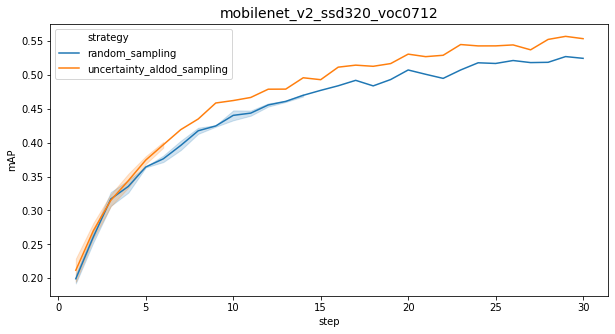

In [7]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='step', y='mAP', hue='strategy', data=df)
plt.title(df.loc[0, 'data'], fontsize=14)

In [8]:
df['step'] = df['step'].astype(np.int32)

Text(0.5, 1.0, 'mobilenet_v2_ssd320_voc0712')

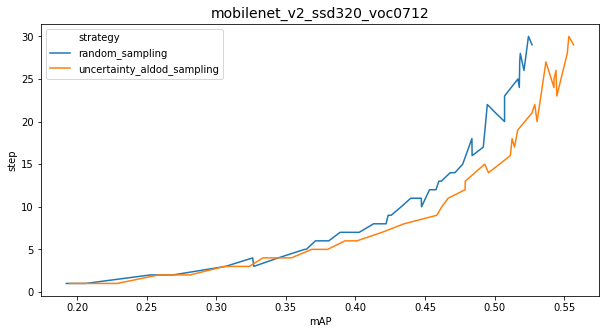

In [9]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='mAP', y='step', hue='strategy', data=df)
plt.title(df.loc[0, 'data'], fontsize=14)

In [10]:
last_time = max(list(map(lambda x: x.split('-')[-1], list(set(df.loc[df.strategy == 'random_sampling'].model)))))

In [11]:
def get_single_experiment(df, model, strategy):
    return df.loc[(df.model == f"{strategy}-{model}"), ['step', 'mAP']].reset_index(drop=True)

In [12]:
df_aldod = get_single_experiment(df, last_time, "uncertainty_aldod_sampling")
df_random = get_single_experiment(df, last_time, "random_sampling")
diff = df_aldod['mAP'] - df_random['mAP']

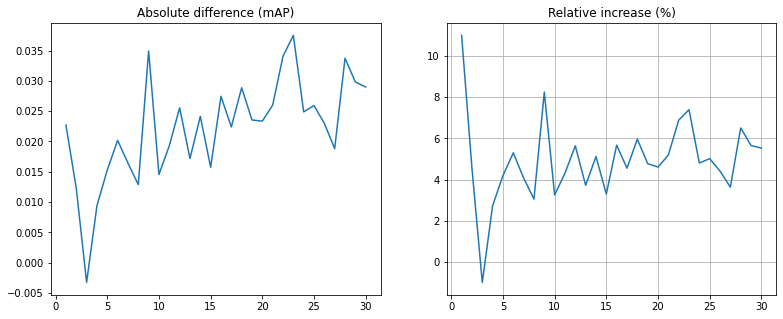

In [13]:
fig, axs = plt.subplots(figsize=(13, 5), ncols=2)
axs[0].plot(df_aldod['step'], diff)
axs[0].set_title('Absolute difference (mAP)')
axs[1].plot(df_aldod['step'], diff/df_random['mAP']*100)
axs[1].set_title('Relative increase (%)')
axs[1].grid()

In [14]:
perfs = np.linspace(df_random['mAP'].min(), df_random['mAP'].max(), 100)
def get_min_step(x, df):
    return (df['mAP'] < x).argmin()
min_random = np.array(list(map(partial(get_min_step, df=df_random), perfs)))
min_aldod = np.array(list(map(partial(get_min_step, df=df_aldod), perfs)))
diff_steps = min_random - min_aldod

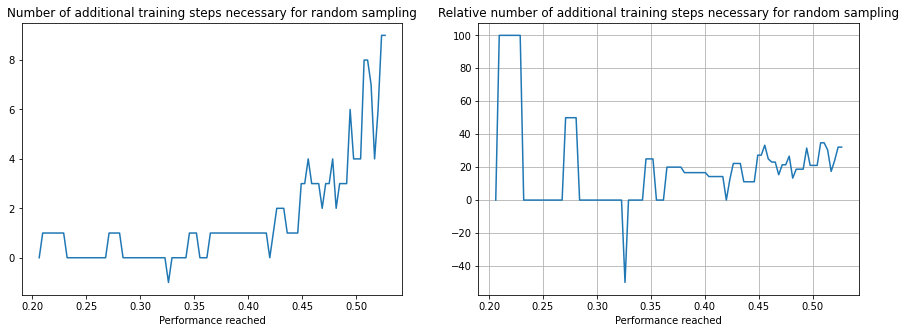

In [15]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=2)
axs[0].plot(perfs, diff_steps)
axs[0].set_xlabel('Performance reached')
axs[0].set_title('Number of additional training steps necessary for random sampling')
axs[1].plot(perfs, diff_steps/np.maximum(1, min_random)*100)
axs[1].set_xlabel('Performance reached')
axs[1].set_title('Relative number of additional training steps necessary for random sampling')
axs[1].grid()

Using active learning for object detection augments by 5% the performance for the same annotation budget, or reduces by 20 to 30% the number of images to annotate for the same performance.